# Set up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/programming projects/SAM'

/content/drive/MyDrive/programming projects/SAM


In [ ]:
!pwd

/content/drive/MyDrive/programming projects/SAM


In [24]:
import os

import cv2
# import torch
import requests
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO
# from torchvision.transforms import Compose

from tunnel_book.DepthAnything.depth_anything.dpt import DepthAnything
from tunnel_book.DepthAnything.depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

from sklearn.cluster import KMeans
# from yellowbrick.cluster import KElbowVisualizer

ModuleNotFoundError: No module named 'torch'

In [19]:
def get_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    return np.array(img)

def get_image_from_files(dir):
  images_list = list()
  for root, dirs, files in os.walk(dir):
    for file in files:
      images_list.append(dir+file)
  print(f'There are {len(images_list)} images in our dataset')
  return images_list

dir = "dataset/"
images_list = get_image_from_files(dir)

There are 23 images in our dataset


In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ogexhpvr
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ogexhpvr
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=290764df787521df6b07e04dd8a4d1b304570e31f26835040f41be79feef30d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-tzem85ml/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [ ]:
!pip install opencv-python pycocotools matplotlib onnxruntime onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.6 MB/s eta 0:00:00


In [ ]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

In [ ]:
using_colab = False # Using colab but have downloaded sam_vit_h_4b8939.pth, set false
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

# Obtain Depth

In [20]:
images_list

['dataset/R0002315.jpg',
 'dataset/torii.jpg',
 'dataset/_DSC9609.jpg',
 'dataset/machine.jpg',
 'dataset/atomic-dome.jpg',
 'dataset/city.jpg',
 'dataset/R0003242.JPG',
 'dataset/R0004856.JPG',
 'dataset/gundam.jpg',
 'dataset/R0004275.JPG',
 'dataset/matterhorn.jpg',
 'dataset/R0004853.JPG',
 'dataset/tetrapod.jpg',
 'dataset/IMG_8569.jpg',
 'dataset/R0001675.jpg',
 'dataset/R0003260.JPG',
 'dataset/_DSC9672.jpg',
 'dataset/R0004899.JPG',
 'dataset/_DSC8141.jpg',
 'dataset/R0004910.JPG',
 'dataset/R0004864.JPG',
 'dataset/crossing.jpg',
 'dataset/description.txt']

In [21]:
raw_image = cv2.imread(images_list[-4])
raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB) / 255.0

In [ ]:
encoder = 'vits' # can also be 'vits', 'vitb' or 'vitl'

transform = Compose([
    Resize(
        width=518,
        height=518,
        resize_target=False,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method='lower_bound',
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    PrepareForNet(),
])

depth_anything = DepthAnything.from_pretrained('LiheYoung/depth_anything_{:}14'.format(encoder)).eval()

In [ ]:
%%time
image_resized = transform({'image': raw_image})['image']
image_resized = torch.from_numpy(image_resized).unsqueeze(0)

depth = depth_anything(image_resized)  # depth shape: 1xHxW
depth = depth.detach().squeeze()

CPU times: user 4.18 s, sys: 1.92 s, total: 6.1 s
Wall time: 1.32 s


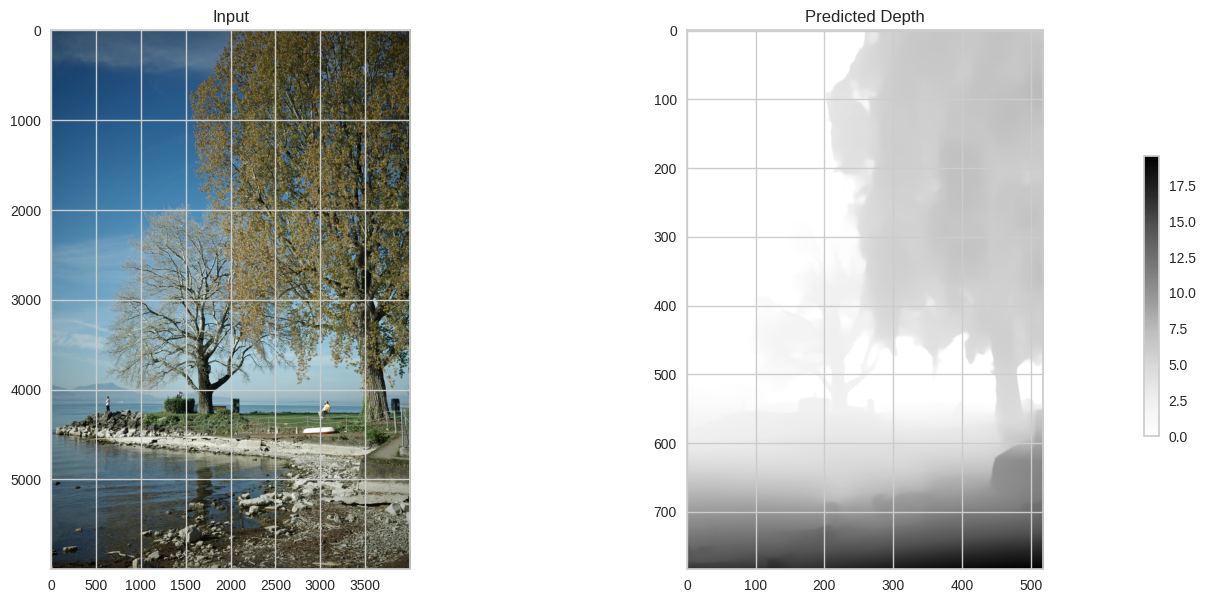

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(121)
plt.title('Input')
plt.imshow(raw_image)

plt.subplot(122)
plt.title('Predicted Depth')
plt.imshow(depth)

plt.colorbar(cax = plt.axes([0.91, 0.3, 0.01, 0.4]))

# Automatic segmentation of all objects

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

## Functions

In [ ]:
from viz import show_anns, show_all_segmts_ind, save_layers
from cut import assign2layers_kmeans
from process_seg_img import downsample_image_opencv,check_overlapping
from PIL import Image, ImageEnhance

## Procedure

In [ ]:
def remove_small_masks(masks, thrds = 500):
  large_masks =[]
  for i, m in enumerate(masks):
    mask = m['segmentation']
    if np.sum(mask) > thrds:
      large_masks.append(m)

  return large_masks


def remove_overlapping(masks, ovlp_r_thrd=0.05):
  embedded_objects = []

  for i in range(len(masks)):
    for j in range(i + 1, len(masks)):
      overlap_area = np.logical_and(masks[i]['segmentation'], masks[j]['segmentation'])

      overlap_size = np.sum(overlap_area)

      mask_i_size = np.sum(masks[i]['segmentation'])
      mask_j_size = np.sum(masks[j]['segmentation'])

      # Calculate the percentage of overlap, relative to smaller masks
      if overlap_size > 0:  # Ensure overlap
        overlap_ratio = round(overlap_size / min(mask_i_size, mask_j_size),4)
        if overlap_ratio > ovlp_r_thrd:
          if mask_i_size > mask_j_size:
            embedded_objects.append(i)
          else:
            embedded_objects.append(j)

  non_ovlp_object_masks = np.delete(masks, embedded_objects).tolist()

  return embedded_objects, non_ovlp_object_masks

def obtain_rest_of_img(object_masks, orignial_img):
  combined_mask = np.sum([m['segmentation'] for m in object_masks], axis=0)
  unsegmented_part = np.where(combined_mask > 0, 0, 1)
  res_img = np.ones_like(orignial_img)
  for i in range(3):
    res_img[:, :, i][unsegmented_part == 1] = orignial_img[:, :, i][unsegmented_part == 1]

  return res_img

def img_white_p_ratio(img):
  return np.sum(img == 1.0)/(img.shape[0]*img.shape[1]*img.shape[2])

def rest_image_pixel_ratio(object_masks):
  num_seg_pixel = 0
  for mask in object_masks:
    m = mask['segmentation']
    num_seg_pixel += np.sum(m)
  return num_seg_pixel/(m.shape[0]*m.shape[1])

def remove_white_canva(res_img, res_masks):
  white_canva_masks = []
  for i, m in enumerate(res_masks):
    mask = m["segmentation"]
    mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    masked_img = res_img * mask

    total_pixels = np.sum(mask)
    if total_pixels > 0:
        ones_ratio = img_white_p_ratio(masked_img)
        # print(f"Proportion of pixels in Mask {i} with value equal to 1: {ones_ratio:.4f}")
        if ones_ratio > 0.5:
          white_canva_masks.append(i)
    # else:
        # print(f"Mask {i} does not cover any area")

  res_masks_no_white_bg = np.delete(res_masks, white_canva_masks).tolist()

  return res_masks_no_white_bg


def obtain_all_objects(mask_generator, img_to_procd, img_r_thrd=0.90, n_thrd=5, ovlp_r_thrd=0.1, small_thrd=1000):

  n = 0
  diff = 1
  object_masks = []
  rows = img_to_procd.shape[0]
  cols = img_to_procd.shape[1]
  img_r = 0

  orignial_img = img_to_procd

  while img_r < img_r_thrd and n <= n_thrd:

    masks = mask_generator.generate(img_to_procd)
    if n > 0:
      masks = remove_white_canva(img_to_procd, masks)

    large_masks = remove_small_masks(masks, small_thrd)
    object_masks.extend(large_masks)
    embedded_objects, object_masks = remove_overlapping(object_masks,ovlp_r_thrd)

    # check_overlapping(object_masks)

    res_img = obtain_rest_of_img(object_masks, orignial_img)

    img_r = round(rest_image_pixel_ratio(object_masks),2)
    # diff = np.sum(np.abs(res_img - img_to_procd))/(rows*cols)
    n += 1
    print(f"Iteration n={n}: white pixel raito after segmentation = {img_r}")

    img_to_procd = res_img

  # plt.imshow(res_img)

  return object_masks

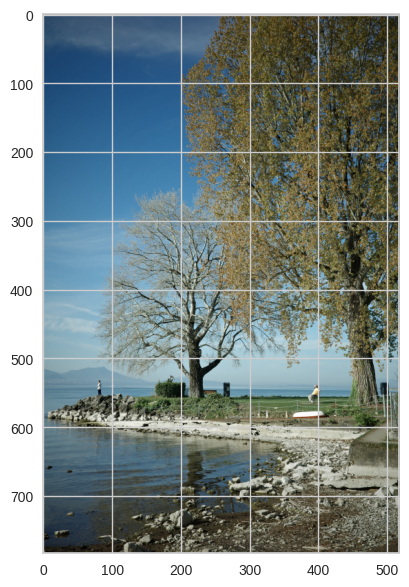

In [ ]:
# Dowsample the original image
img_lr = downsample_image_opencv(raw_image, depth.shape)
plt.figure(figsize=(15,7))
plt.imshow(img_lr)
plt.show()

In [ ]:
object_masks = obtain_all_objects(mask_generator, img_lr, img_r_thrd=0.94, n_thrd = 10, ovlp_r_thrd=0.05, small_thrd=500)

Iteration n=1: white pixel raito after segmentation = 0.51
Iteration n=2: white pixel raito after segmentation = 0.7
Iteration n=3: white pixel raito after segmentation = 0.69
Iteration n=4: white pixel raito after segmentation = 0.81
Iteration n=5: white pixel raito after segmentation = 0.81
Iteration n=6: white pixel raito after segmentation = 0.81
Iteration n=7: white pixel raito after segmentation = 0.81
Iteration n=8: white pixel raito after segmentation = 0.81
Iteration n=9: white pixel raito after segmentation = 0.81
Iteration n=10: white pixel raito after segmentation = 0.81
Iteration n=11: white pixel raito after segmentation = 0.81


In [ ]:
# check_overlapping(object_masks)

There is 21 object masks


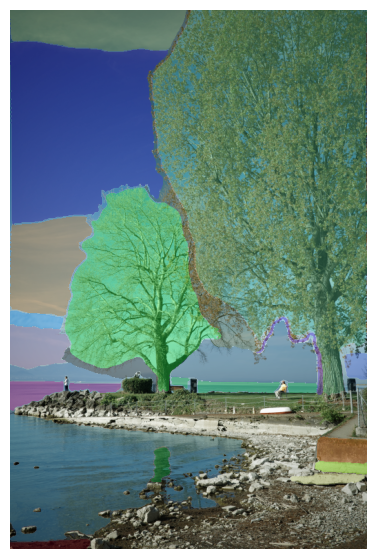

In [ ]:
print(f"There is {len(object_masks)} object masks")
plt.figure(figsize=(15,7))
plt.imshow(img_lr)
show_anns(object_masks)
plt.axis('off')
plt.show()

In [ ]:
# show_all_segmts_ind(object_masks, img_lr)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

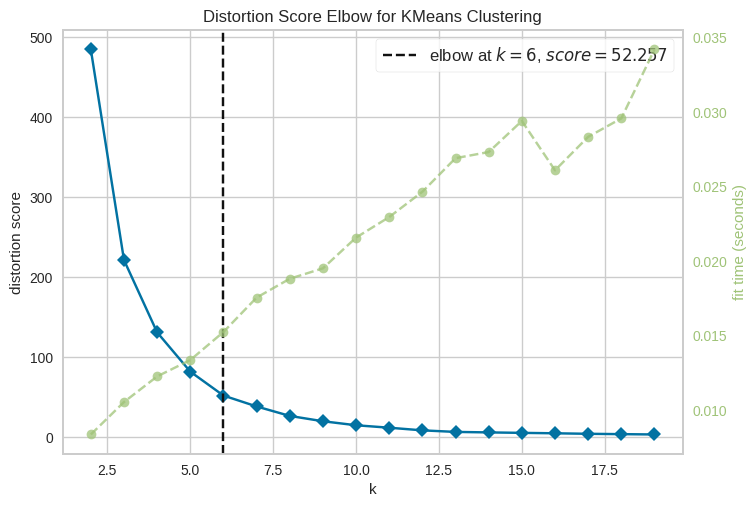

Optimal number of clusters: 6


In [ ]:
depth_features = []
for m in object_masks:
  mask = m['segmentation']
  mask_tensor = torch.tensor(mask, dtype=torch.bool)
  mask_depth = depth[mask_tensor]
  if mask_depth.numel() > 0:
    average_depth = torch.mean(mask_depth.float())
    depth_features.append([average_depth.item()])

depth_features = np.array(depth_features)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,20), metric='distortion', timings=True)
visualizer.fit(depth_features)
visualizer.show()

optimalK = visualizer.elbow_value_
print(f"Optimal number of clusters: {optimalK}")


# Assign objects to layers based on depth

In [ ]:
layers_idx, layers, layer_depth = assign2layers_kmeans(object_masks, depth.numpy(), optimalK)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


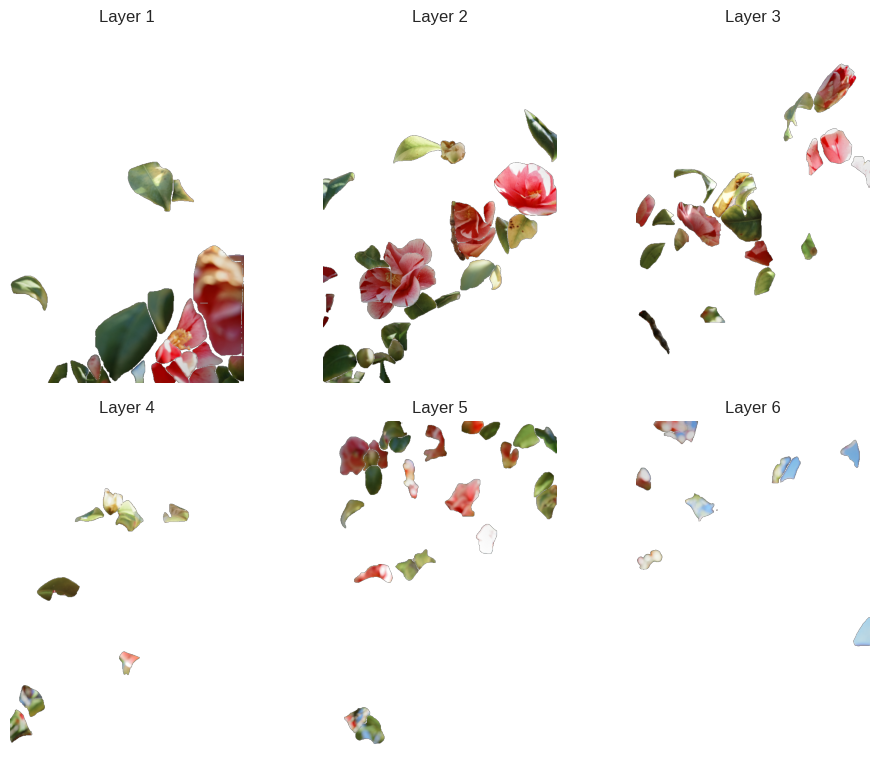

In [ ]:
output_dir = 'images_output/'
name = 'flower_layer'
paths = [output_dir + name + str(i) + '.png' for i in range(1,optimalK+1)]
save_layers(img_lr, object_masks, layers_idx, paths)

In [ ]:
layer_masks = []
for l in layers:
  mob = []
  for ob in l:
    m = ob['segmentation']
    mob.append(m)
  layer_masks.append(mob)

In [ ]:
for i in range(0,optimalK):
  np.save(output_dir + name + str(i-1) + '.npy', layer_masks[i])